In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
if(torch.cuda.is_available()):
    device = torch.device('cuda')
elif(torch.backends.mps.is_available()):
    device = torch.device('mps')
else:
    device = torch.device('cpu')

In [3]:
IMAGE_SIZE = 32
batch_size = 32
mean, std = torch.tensor([0.4914, 0.4822, 0.4465]), torch.tensor([0.247, 0.243, 0.261])
# These values are mostly used by researchers as found to very useful in fast convergence


transform = transforms.Compose([
    transforms.RandomRotation(0.2) ,
    transforms.RandomHorizontalFlip() ,
    transforms.RandomVerticalFlip() ,
    transforms.ColorJitter(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])



train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
val_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size , shuffle = True)

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size , shuffle = False)

classes = [ 'airplane', 'automobile', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']





  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


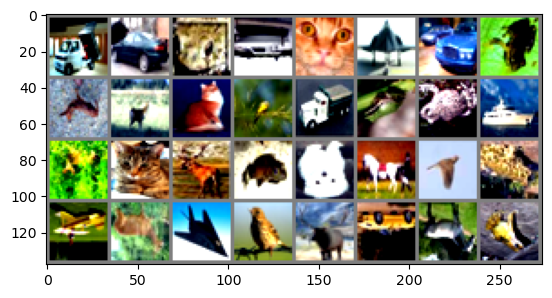

truck automobile frog  ship  cat   airplane automobile frog  deer  deer  cat   bird  truck frog  frog  ship  deer  cat   deer  frog  dog   horse bird  frog  airplane deer  airplane bird  deer  automobile horse frog 


In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [5]:
print(train_dataset.data.shape  , " - " , val_dataset.data.shape)
print(len(train_dataset.targets))

(50000, 32, 32, 3)  -  (10000, 32, 32, 3)
50000


In [6]:
# functions to show an image

def unnormalize(img):
        # unnormalize
    img[0]= img[0]*std[0] + mean[0]
    img[1]= img[1]*std[1] + mean[1]
    img[2]= img[2]*std[2] + mean[2]
    return img
    
def imshow(img):
    # unnormalize
    img = unnormalize(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
def im_convert(tensor):
    img = tensor.cpu().clone().detach().numpy() #
    img = img.transpose(1, 2, 0)
    img = img * np.array(tuple(mean)) + np.array(tuple(std))
    img = img.clip(0, 1) # Clipping the size to print the images later
    return img


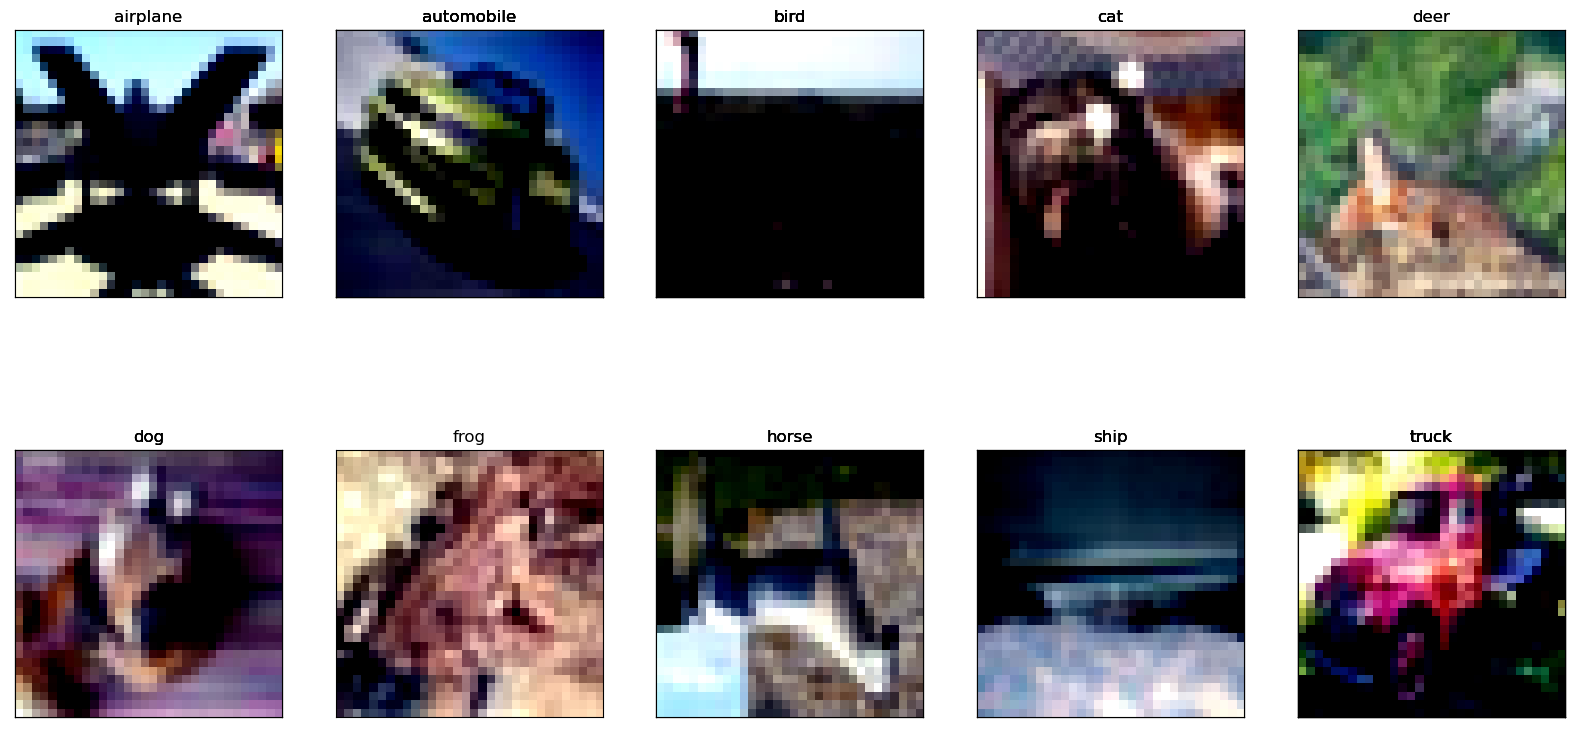

In [7]:
fig = plt.figure(figsize=(20, 10)) 

for i in range(len(classes)):
    dataiter = iter(train_loader)
    images, labels = next(dataiter)
    for j in range (len(labels)):
        if(labels[j].item() == i):
            ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
            plt.imshow(im_convert(images[j]))
            ax.set_title(classes[i])



airplane


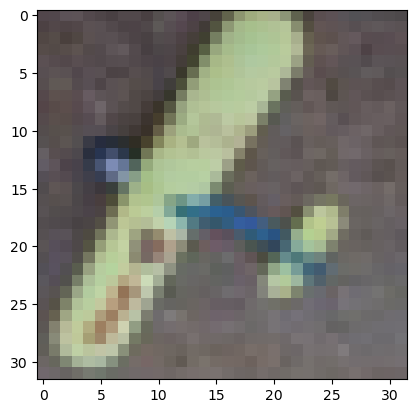

automobile


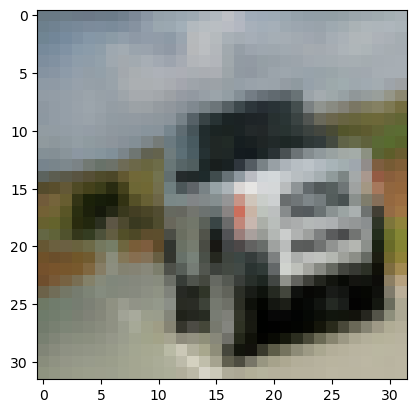

bird


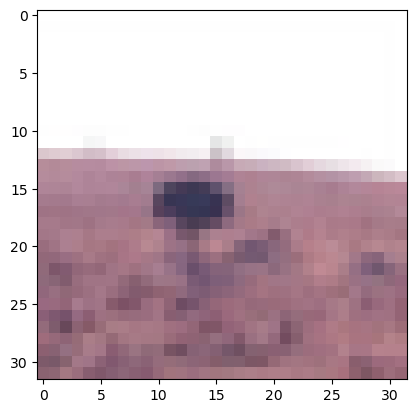

cat


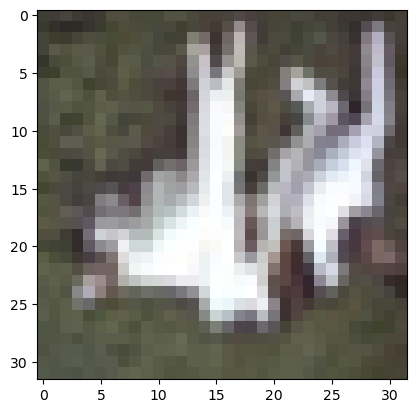

deer


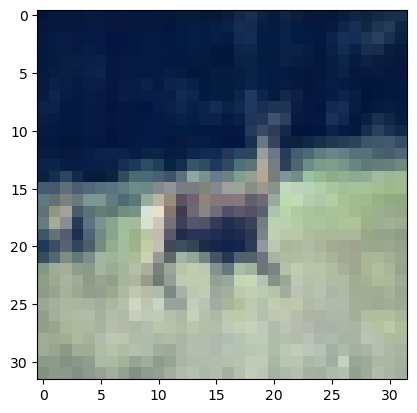

dog


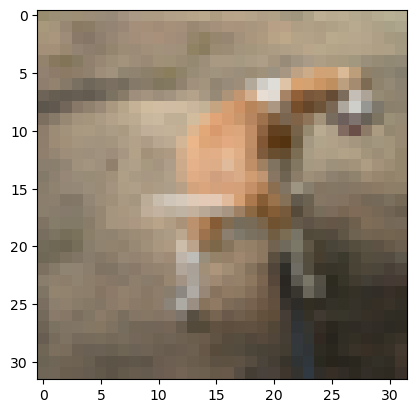

frog


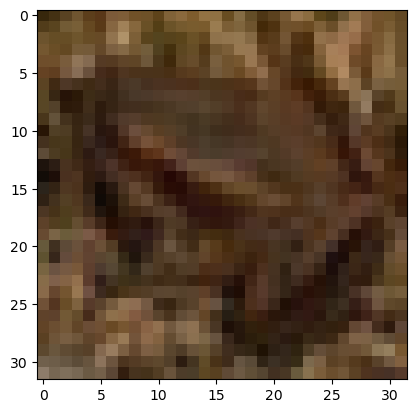

horse


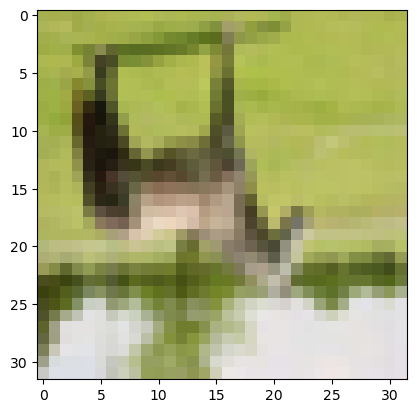

ship


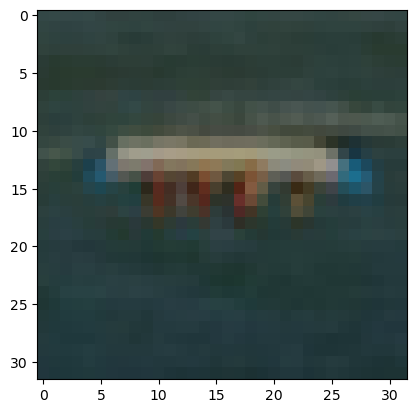

truck


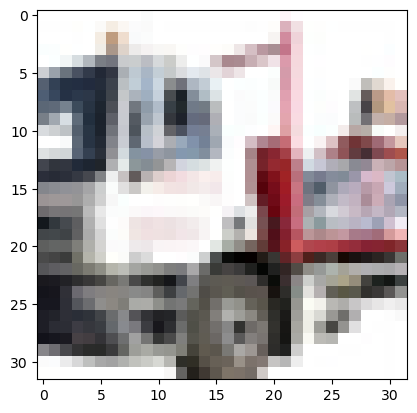

In [8]:
for i in range(len(classes)):
    dataiter = iter(train_loader)
    images, labels = next(dataiter)
    for j in range (len(labels)):
        if(labels[j].item() == i):
            print(classes[i])
            imshow(images[j])
            break

In [9]:
class Net(nn.Module):

    def __init__(self):
        
        super().__init__()
        self.conv1 =nn.Conv2d(3, 32, kernel_size = 3, padding = 2)
        self.conv2 = nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1)
        self.conv4 = nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv5 = nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1)
        self.conv6 = nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1)
        self.bn3 = nn.BatchNorm2d(256)


        self.fc1 = nn.Linear(4096,1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(F.relu(self.conv2(self.bn1(x))), (2, 2))
        
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(F.relu(self.conv4(self.bn2(x))), (2, 2))
        
        x = F.relu(self.conv5(x))
        x = F.max_pool2d(F.relu(self.conv6(self.bn3(x))), (2, 2))
        
        x = torch.flatten(x ,1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
        

In [10]:
model = Net()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001,momentum=0.9)

In [11]:
num_epochs = 50
# Training loop
train_acc = []
train_loss = []
val_acc = []
val_loss = []
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    model.train()  # Set the model to training mode

    for images, labels in train_loader:
        images = images.to(device)  # Move the input tensor to the GPU
        labels = labels.to(device)  # Move the labels tensor to the GPU

        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    training_loss = running_loss / len(train_loader)
    training_accuracy = 100 * correct_train / total_train
    

    # Evaluation on test set
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)  # Move the input tensor to the GPU
            labels = labels.to(device)  # Move the labels tensor to the GPU

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # Calculate test accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_loss /= len(val_loader)
    test_accuracy = 100 * correct_test / total_test
    
    train_acc.append(training_accuracy)
    train_loss.append(training_loss)
    val_acc.append(test_accuracy)
    val_loss.append(test_loss)

    # Print the average loss and accuracy for this epoch
    print(f"Epoch {epoch+1}:")
    print(f"  Train Loss: {training_loss:.4f} | Train Accuracy: {training_accuracy:.2f}%")
    print(f"  Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.2f}%")
    print("*************************")

Epoch 1:
  Train Loss: 1.5585 | Train Accuracy: 42.05%
  Test Loss: 1.2394 | Test Accuracy: 54.47%
*************************
Epoch 2:
  Train Loss: 1.0603 | Train Accuracy: 61.69%
  Test Loss: 0.9588 | Test Accuracy: 65.62%
*************************
Epoch 3:
  Train Loss: 0.8683 | Train Accuracy: 68.99%
  Test Loss: 0.8800 | Test Accuracy: 68.96%
*************************
Epoch 4:
  Train Loss: 0.7656 | Train Accuracy: 72.63%
  Test Loss: 0.7519 | Test Accuracy: 73.37%
*************************
Epoch 5:
  Train Loss: 0.6860 | Train Accuracy: 75.67%
  Test Loss: 0.7309 | Test Accuracy: 73.69%
*************************
Epoch 6:
  Train Loss: 0.6220 | Train Accuracy: 78.10%
  Test Loss: 0.6539 | Test Accuracy: 76.60%
*************************
Epoch 7:
  Train Loss: 0.5694 | Train Accuracy: 80.01%
  Test Loss: 0.6909 | Test Accuracy: 75.80%
*************************
Epoch 8:
  Train Loss: 0.5259 | Train Accuracy: 81.53%
  Test Loss: 0.6144 | Test Accuracy: 78.29%
*************************


In [12]:
final_state = model.state_dict()
torch.save(final_state, 'model_state.pth')

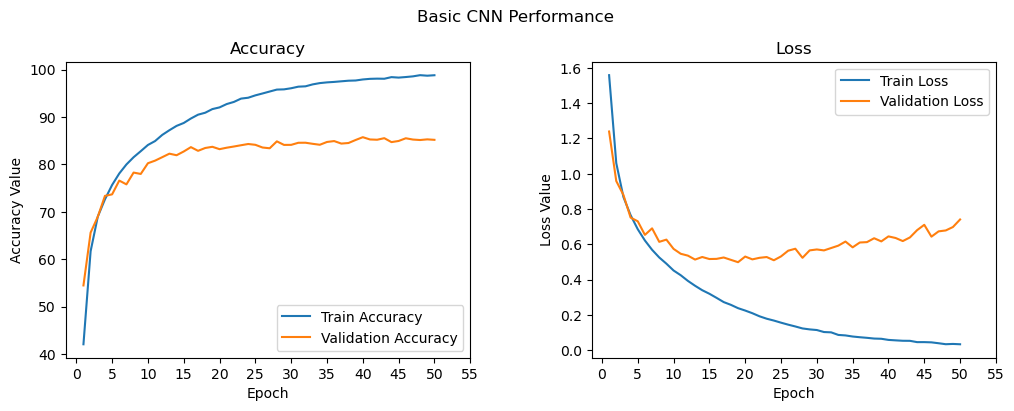

In [13]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,num_epochs+1))
ax1.plot(epoch_list, train_acc, label='Train Accuracy')
ax1.plot(epoch_list, val_acc, label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 60, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, train_loss, label='Train Loss')
ax2.plot(epoch_list, val_loss, label='Validation Loss')
ax2.set_xticks(np.arange(0, 60, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")